# Exploring Models for Predicting the SP500 Returns at a Monthly-Level

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.

1. **[Part 1: EDA and Data Processing](#part1)**
- **Objective**: Perform Exploratory Data Analysis and Data Preprocessing
- **Tasks:**
   - Explore Data
   - Conduct preprocessing & Feature Engineering
   - Feature creation: Create multiple types of lag variables for different lag amounts.

2. **[Part 2: ARMA Model](#part2)**
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model as a Baseline Model to Compare with more Advanced Models

3. **[Part 3: Gaussian Process Model](#part3)**
- **Objective**: Create a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - Feature selection: Random Forest Feature Selection
  - Create a gaussian process, discuss hyper parameter tuning.

4. **[Part 4: Neural Network Model](#part4)**
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - Feature selection: Random Forest Feature Selection
  - Create a neural network, discuss hyper parameter tuning.

## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

In [35]:
#Libraries
import pandas as pd
import numpy as np
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # For generic user warnings

#Paths
data_path = "/Users/amber/projects/SP500-Prediction-NN-GP/data/"

## <a id='part1'> Part 1: EDA and Data Processing</a>
- **Objective**: Perform Exploratory Data Analysis and Data Preprocessing
- **Tasks:**
   - Explore Data
   - Conduct preprocessing & Feature Engineering
   - Feature creation: Create multiple types of lag variables for different lag amounts.

### Load and Clean Data

In [2]:
sp500_data = pd.read_csv(data_path + 'goyal-welch2022Monthly.csv', sep=',')
sp500_data.columns = sp500_data.columns.str.lower().str.strip()
sp500_data['date'] = pd.to_datetime(sp500_data['yyyymm'], format='%Y%m')
sp500_data['index'] = sp500_data['index'].astype(str).str.replace(',', '').astype(float)
sp500 = sp500_data[sp500_data['date'] >= '1926-01-01']

sp500_head = sp500.head()
sp500_info = sp500.info()
sp500_description = sp500.describe()

sp500_head, sp500_info, sp500_description

<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 660 to 1823
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymm      1164 non-null   int64         
 1   index       1164 non-null   float64       
 2   d12         1164 non-null   float64       
 3   e12         1164 non-null   float64       
 4   b/m         1164 non-null   float64       
 5   tbl         1164 non-null   float64       
 6   aaa         1164 non-null   float64       
 7   baa         1164 non-null   float64       
 8   lty         1164 non-null   float64       
 9   ntis        1153 non-null   float64       
 10  rfree       1164 non-null   float64       
 11  infl        1164 non-null   float64       
 12  ltr         1164 non-null   float64       
 13  corpr       1164 non-null   float64       
 14  svar        1164 non-null   float64       
 15  csp         788 non-null    float64       
 16  crsp_spvw   1164 non-null  

(     yyyymm  index     d12    e12  ...  csp  crsp_spvw  crsp_spvwx       date
 660  192601  12.74  0.6075  1.249  ...  NaN  -0.001783   -0.003980 1926-01-01
 661  192602  12.18  0.6150  1.248  ...  NaN  -0.033296   -0.037876 1926-02-01
 662  192603  11.46  0.6225  1.248  ...  NaN  -0.057708   -0.062007 1926-03-01
 663  192604  11.72  0.6300  1.247  ...  NaN   0.038522    0.034856 1926-04-01
 664  192605  11.81  0.6375  1.246  ...  NaN   0.013623    0.009070 1926-05-01
 
 [5 rows x 19 columns],
 None,
               yyyymm        index  ...   crsp_spvwx                           date
 count    1164.000000  1164.000000  ...  1164.000000                           1164
 mean   197406.500000   558.088479  ...     0.006304  1974-06-16 13:58:45.773195872
 min    192601.000000     4.430000  ...    -0.291524            1926-01-01 00:00:00
 25%    195003.750000    22.857500  ...    -0.019211            1950-03-24 06:00:00
 50%    197406.500000    98.945000  ...     0.009393            1974-06-1

In [3]:
sp500.isna().sum()

yyyymm          0
index           0
d12             0
e12             0
b/m             0
tbl             0
aaa             0
baa             0
lty             0
ntis           11
rfree           0
infl            0
ltr             0
corpr           0
svar            0
csp           376
crsp_spvw       0
crsp_spvwx      0
date            0
dtype: int64

Let's check for any patterns in the missing data

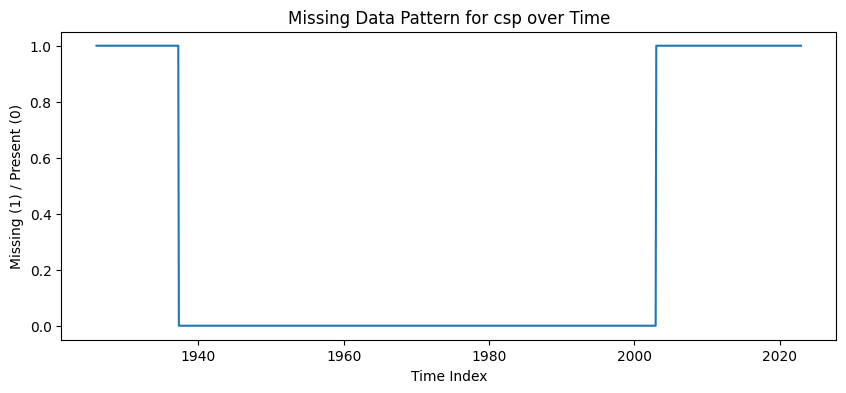

In [4]:
missing_csp = sp500['csp'].isna()
missing = missing_csp.astype(int)

plt.figure(figsize=(10, 4))
sns.lineplot(x=sp500['date'], y=missing) # Replace 'time_index' if needed
plt.xlabel("Time Index") # Adjust if using a different x-axis variable
plt.ylabel("Missing (1) / Present (0)")
plt.title("Missing Data Pattern for csp over Time")
plt.show()


Looks like data is missing for csp starting in the early 2000s, it's too much to impute so we will leave this variable out during analysis

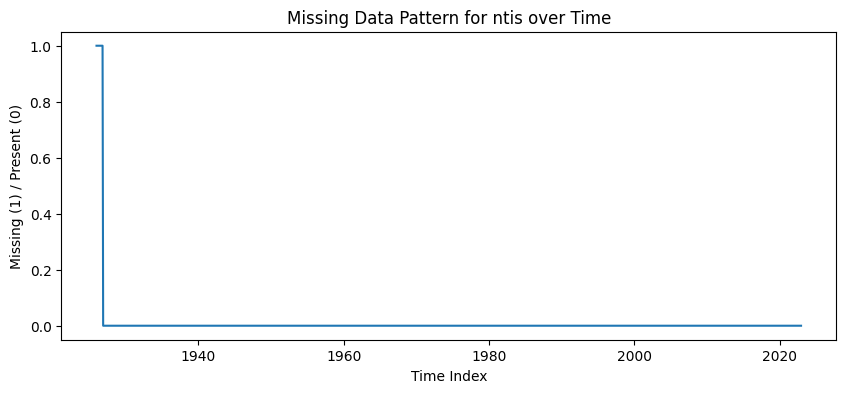

In [5]:
missing_csp = sp500['ntis'].isna()
missing = missing_csp.astype(int)

plt.figure(figsize=(10, 4))
sns.lineplot(x=sp500['date'], y=missing) # Replace 'time_index' if needed
plt.xlabel("Time Index") # Adjust if using a different x-axis variable
plt.ylabel("Missing (1) / Present (0)")
plt.title("Missing Data Pattern for ntis over Time")
plt.show()

The data is only missing in the far past, so we will drop the data before that data

### Explore the Target Variable

<Axes: >

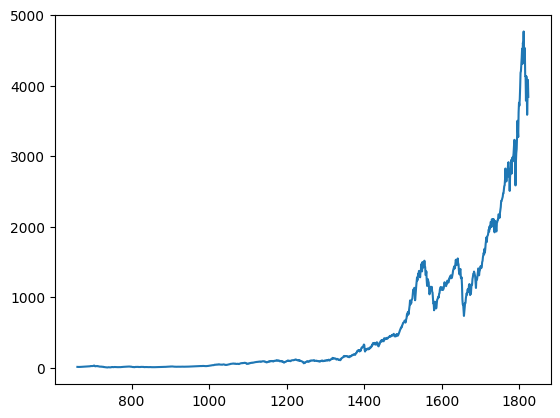

In [6]:
sp500['index'].plot()

We can see that the index (price) is not stationary, so we will work to fix that.

C:\Users\amber\AppData\Local\Temp\ipykernel_42256\2954293126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['first_diff'] = sp500['index'] - sp500['index'].shift()


<Axes: >

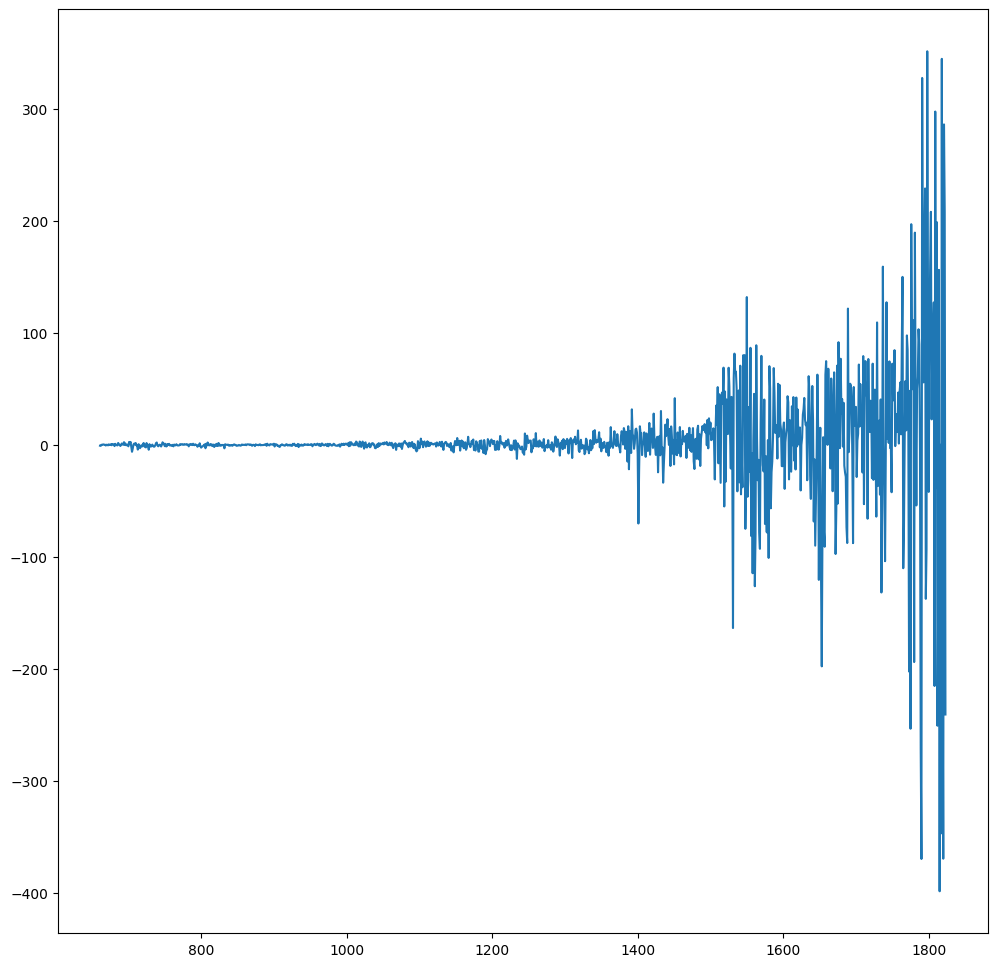

In [7]:
sp500['first_diff'] = sp500['index'] - sp500['index'].shift()
sp500['first_diff'].plot(figsize=(12, 12))

It is no longer trending up and is instead centered aroudn zero, but variance is small in the beginning then increases expoenentially. Let's apply a log transformation to fix it.

C:\Users\amber\AppData\Local\Temp\ipykernel_42256\3396915461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['log_index'] = sp500['index'].apply(lambda x: np.log(x))


<Axes: >

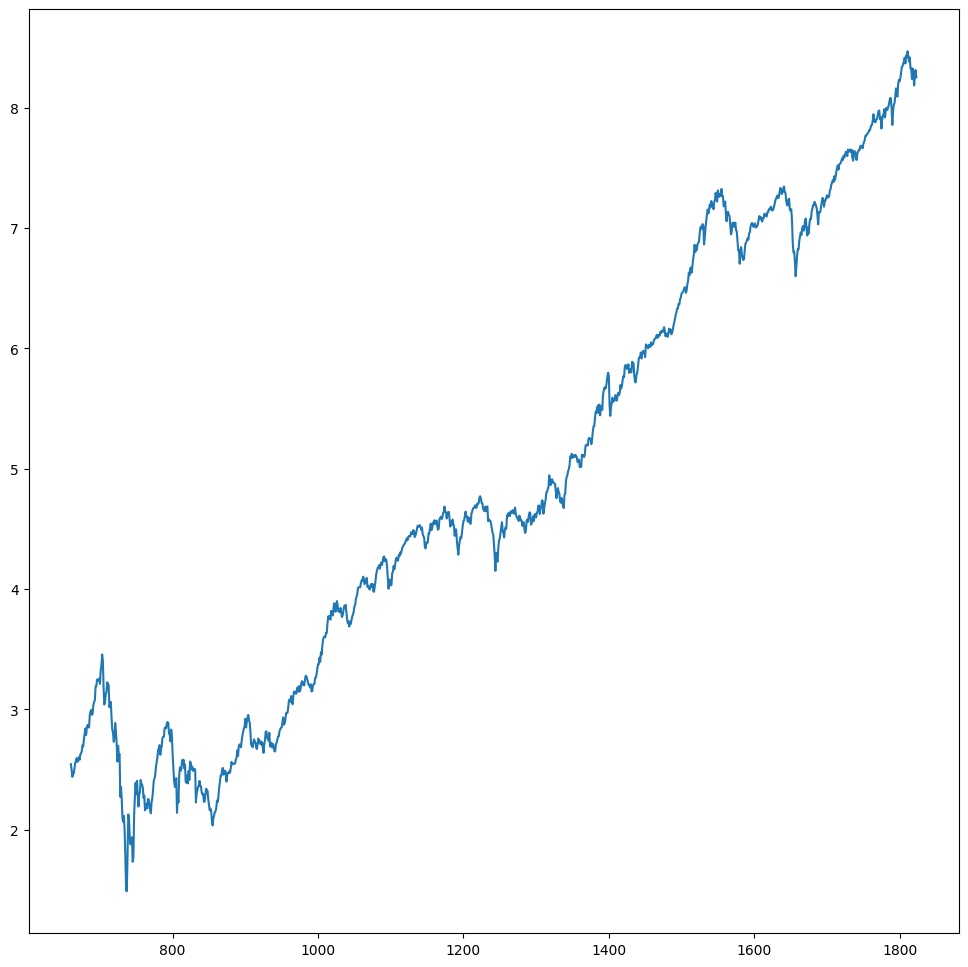

In [9]:
sp500['log_index'] = sp500['index'].apply(lambda x: np.log(x))
sp500['log_index'].plot(figsize=(12, 12))


we falttened the exp curve to a linear curve which will make our time series forcast much easier. Let's check the variance.

C:\Users\amber\AppData\Local\Temp\ipykernel_42256\3399071204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['og_var'] = sp500['index'].rolling(window=30, center=True).var()
C:\Users\amber\AppData\Local\Temp\ipykernel_42256\3399071204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['log_var'] = sp500['log_index'].rolling(window=30, center=True).var()


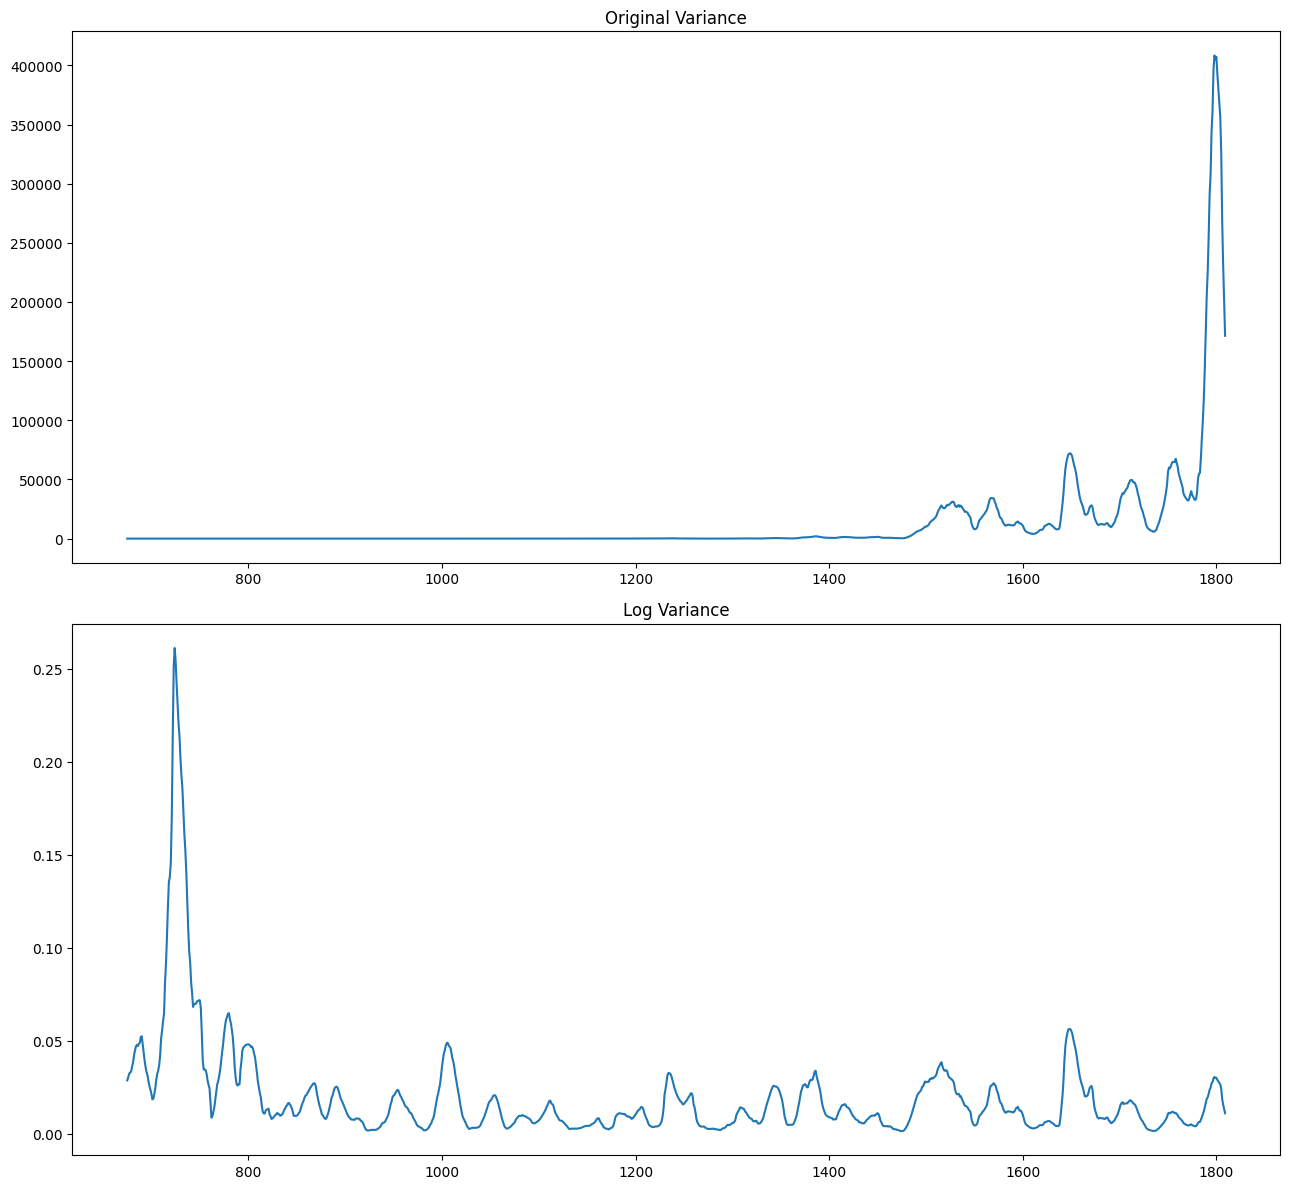

In [10]:
sp500['og_var'] = sp500['index'].rolling(window=30, center=True).var()
sp500['log_var'] = sp500['log_index'].rolling(window=30, center=True).var()

fig, ax = plt.subplots(2, 1, figsize=(13, 12))
sp500['og_var'].plot(ax=ax[0], title="Original Variance")
sp500['log_var'].plot(ax=ax[1], title="Log Variance")
fig.tight_layout()

We can see that the log transformation helped makes the differences in values more clear.
Now we still need to take the difference of the log transformation. When we take the first difference of the sp500 price, we are essentially calculating the return of the price. So we will name this new target vaiable the log of returns.

C:\Users\amber\AppData\Local\Temp\ipykernel_42256\2852777093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['log_return'] = sp500['log_index'] - sp500['log_index'].shift()


<Axes: >

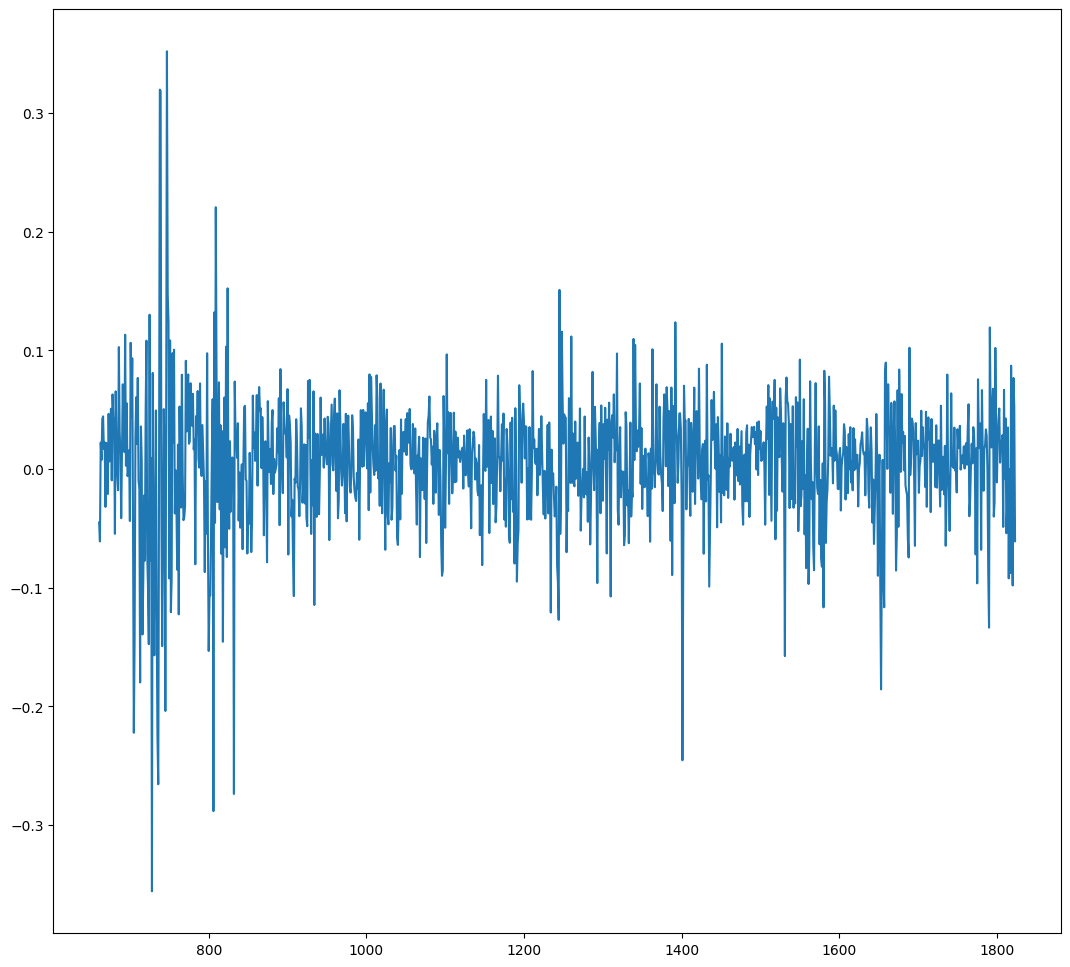

In [11]:
sp500['log_return'] = sp500['log_index'] - sp500['log_index'].shift()
sp500['log_return'].plot(figsize=(13, 12))

Now we have a stationary time series model of the mothly changes to the S&P index, which is technically now the log of monthly returns

Now let's check if there are any correlations between index and the lags of the variable an auto-correlation function.

In [12]:
print(sp500['log_return'].head())
print(sp500['log_return'].describe())


660         NaN
661   -0.044951
662   -0.060933
663    0.022434
664    0.007650
Name: log_return, dtype: float64
count    1163.000000
mean        0.004908
std         0.053985
min        -0.355851
25%        -0.019731
50%         0.009356
75%         0.035419
max         0.352221
Name: log_return, dtype: float64


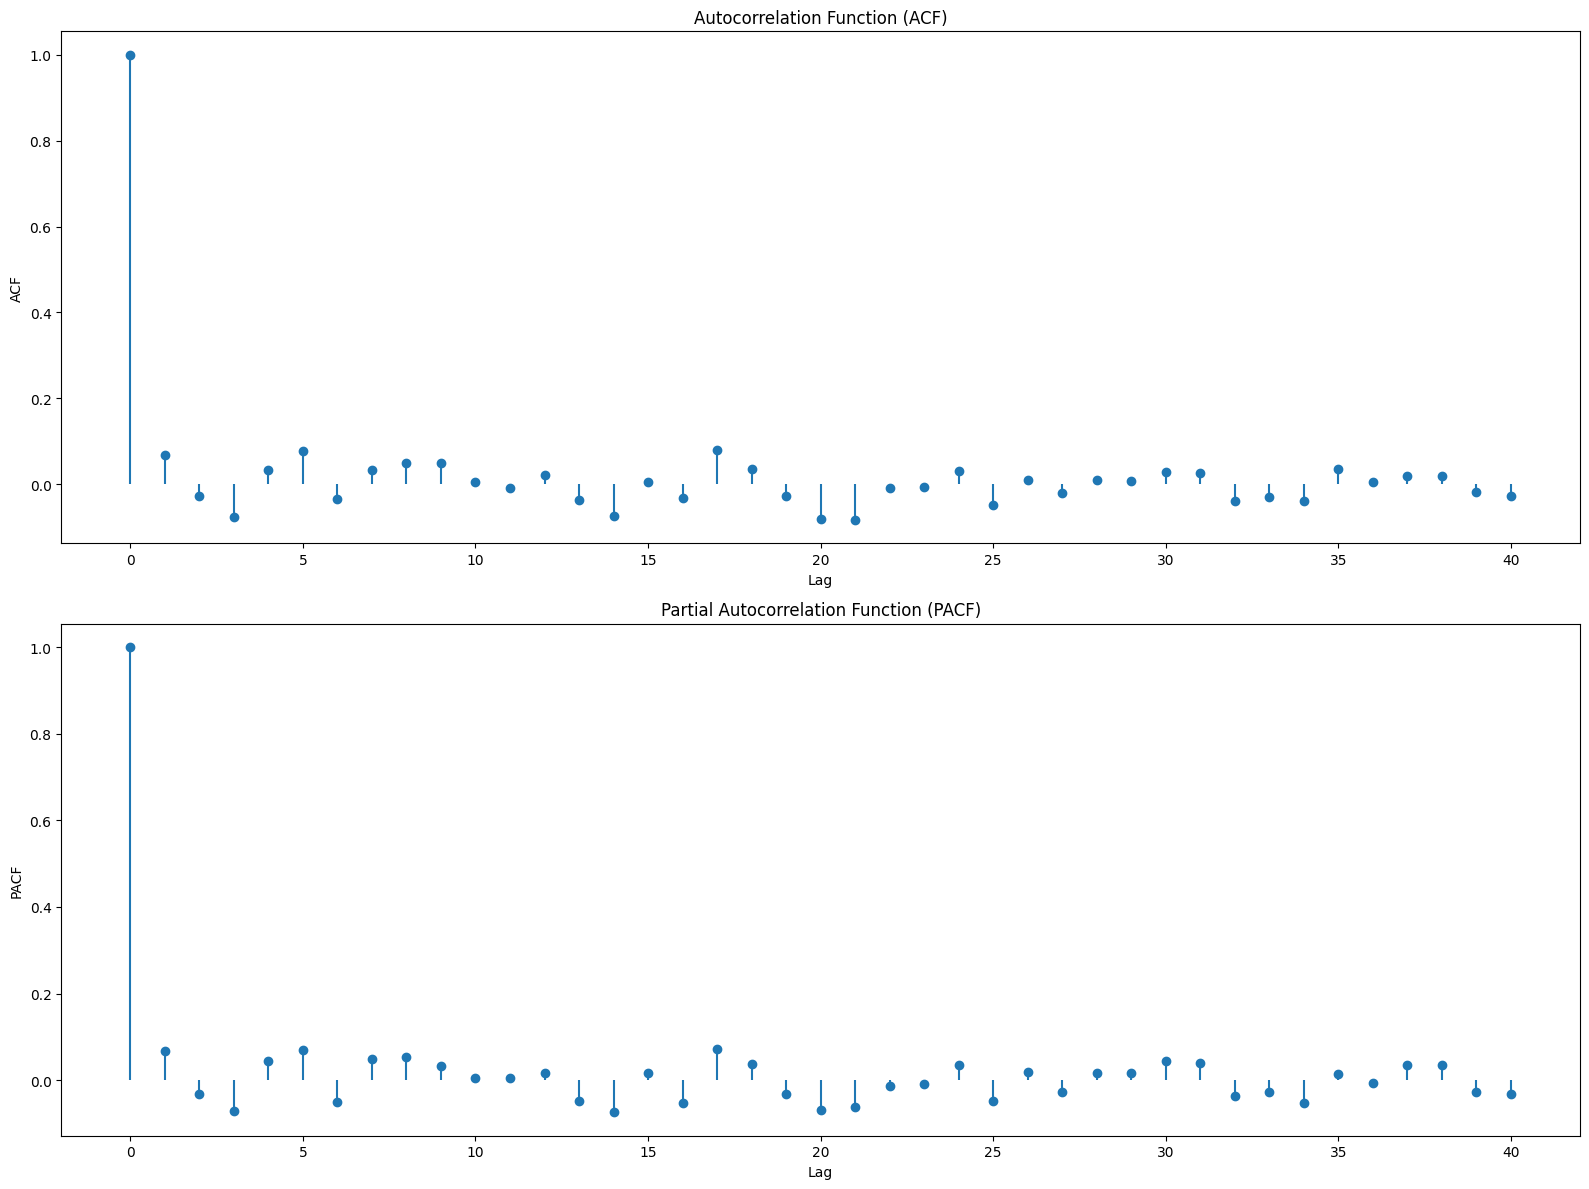

In [13]:
# Calculate ACF and PACF (exclude lag 0 for clarity in plotting)
lag_correlations = acf(sp500['log_return'].dropna(), nlags=40)
lag_partial_correlations = pacf(sp500['log_return'].dropna(), nlags=40)

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

# Plot ACF
ax[0].stem(range(len(lag_correlations)), lag_correlations, basefmt=" ")
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("ACF")

# Plot PACF
ax[1].stem(range(len(lag_partial_correlations)), lag_partial_correlations, basefmt=" ")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("PACF")

plt.tight_layout()
plt.show()

All of the lags are under 0.2 indicating that none of them really have a stong correlation. Meaning the series is a random walk which makes sense, the stock market is not predictable.

### Feature Engineering

In [14]:
sp500_df = sp500.copy()
sp500_df['index'] = pd.to_numeric(sp500_df['index'], errors='coerce')
sp500_df['d12'] = pd.to_numeric(sp500_df['d12'], errors='coerce')
sp500_df['rfree'] = pd.to_numeric(sp500_df['rfree'], errors='coerce')

print(sp500_df.dtypes)

yyyymm                 int64
index                float64
d12                  float64
e12                  float64
b/m                  float64
tbl                  float64
aaa                  float64
baa                  float64
lty                  float64
ntis                 float64
rfree                float64
infl                 float64
ltr                  float64
corpr                float64
svar                 float64
csp                  float64
crsp_spvw            float64
crsp_spvwx           float64
date          datetime64[ns]
first_diff           float64
og_var               float64
log_index            float64
log_var              float64
log_return           float64
dtype: object


In [15]:
# dividend-price ratio (dp)
sp500_df['dp'] = np.log(sp500_df['d12']) - np.log(sp500_df['index'])

# Book-to-Market (b/m)
sp500_df.rename(columns={'b/m': 'bm'}, inplace=True)

print(sp500_df.head())

     yyyymm  index     d12    e12  ...  log_index  log_var  log_return        dp
660  192601  12.74  0.6075  1.249  ...   2.544747      NaN         NaN -3.043150
661  192602  12.18  0.6150  1.248  ...   2.499795      NaN   -0.044951 -2.985928
662  192603  11.46  0.6225  1.248  ...   2.438863      NaN   -0.060933 -2.912874
663  192604  11.72  0.6300  1.247  ...   2.461297      NaN    0.022434 -2.923332
664  192605  11.81  0.6375  1.246  ...   2.468947      NaN    0.007650 -2.919148

[5 rows x 25 columns]


In [16]:
sp500_df['logret'] = np.log(sp500_df['index']).diff() #log return of sp500
sp500_df['logindex'] = np.log(sp500_df['index']) #log of index

print(sp500_df[['date', 'logindex', 'logret']].head())

          date  logindex    logret
660 1926-01-01  2.544747       NaN
661 1926-02-01  2.499795 -0.044951
662 1926-03-01  2.438863 -0.060933
663 1926-04-01  2.461297  0.022434
664 1926-05-01  2.468947  0.007650


In [17]:
sp500_df['log_return'].head()

660         NaN
661   -0.044951
662   -0.060933
663    0.022434
664    0.007650
Name: log_return, dtype: float64

In [18]:
#lags for dp
sp500_df['dp_lag1'] = sp500_df['dp'].shift(1)
sp500_df['dp_lag2'] = sp500_df['dp'].shift(2)
sp500_df['dp_lag3'] = sp500_df['dp'].shift(3)
sp500_df['dp_lag4'] = sp500_df['dp'].shift(4)

#lags for svar
sp500_df['svar_lag1'] = sp500_df['svar'].shift(1)
sp500_df['svar_lag2'] = sp500_df['svar'].shift(2)
sp500_df['svar_lag3'] = sp500_df['svar'].shift(3)
sp500_df['svar_lag4'] = sp500_df['svar'].shift(4)

#lags for bm
sp500_df['bm_lag1'] = sp500_df['bm'].shift(1)
sp500_df['bm_lag2'] = sp500_df['bm'].shift(2)
sp500_df['bm_lag3'] = sp500_df['bm'].shift(3)
sp500_df['bm_lag4'] = sp500_df['bm'].shift(4)

#lags for target: log of return
sp500_df['logret_lag1'] = sp500_df['log_return'].shift(1)
sp500_df['logret_lag2'] = sp500_df['log_return'].shift(2)
sp500_df['logret_lag3'] = sp500_df['log_return'].shift(3)
sp500_df['logret_lag4'] = sp500_df['log_return'].shift(4)

sp500_df.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,rfree,infl,ltr,corpr,svar,csp,crsp_spvw,crsp_spvwx,date,first_diff,og_var,log_index,log_var,log_return,dp,logret,logindex,dp_lag1,dp_lag2,dp_lag3,dp_lag4,svar_lag1,svar_lag2,svar_lag3,svar_lag4,bm_lag1,bm_lag2,bm_lag3,bm_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4
660,192601,12.74,0.6075,1.249,0.387671,0.0349,0.0482,0.0609,0.0374,NaN,0.002925,0.000000,0.0138,0.0072,0.000857,NaN,-0.001783,-0.003980,1926-01-01,NaN,NaN,2.544747,NaN,NaN,-3.043150,NaN,2.544747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,192602,12.18,0.6150,1.248,0.394363,0.0318,0.0477,0.0602,0.0372,NaN,0.002908,0.000000,0.0063,0.0045,0.001099,NaN,-0.033296,-0.037876,1926-02-01,-0.56,NaN,2.499795,NaN,-0.044951,-2.985928,-0.044951,2.499795,-3.043150,NaN,NaN,NaN,0.000857,NaN,NaN,NaN,0.387671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662,192603,11.46,0.6225,1.248,0.494091,0.0314,0.0479,0.0605,0.0371,NaN,0.002650,-0.005587,0.0041,0.0084,0.006016,NaN,-0.057708,-0.062007,1926-03-01,-0.72,NaN,2.438863,NaN,-0.060933,-2.912874,-0.060933,2.438863,-2.985928,-3.043150,NaN,NaN,0.001099,0.000857,NaN,NaN,0.394363,0.387671,NaN,NaN,-0.044951,NaN,NaN,NaN
663,192604,11.72,0.6300,1.247,0.482917,0.0308,0.0474,0.0598,0.0368,NaN,0.002617,0.005618,0.0076,0.0097,0.001466,NaN,0.038522,0.034856,1926-04-01,0.26,NaN,2.461297,NaN,0.022434,-2.923332,0.022434,2.461297,-2.912874,-2.985928,-3.043150,NaN,0.006016,0.001099,0.000857,NaN,0.494091,0.394363,0.387671,NaN,-0.060933,-0.044951,NaN,NaN
664,192605,11.81,0.6375,1.246,0.483860,0.0317,0.0471,0.0586,0.0369,NaN,0.002567,-0.005587,0.0014,0.0044,0.000690,NaN,0.013623,0.009070,1926-05-01,0.09,NaN,2.468947,NaN,0.007650,-2.919148,0.007650,2.468947,-2.923332,-2.912874,-2.985928,-3.04315,0.001466,0.006016,0.001099,0.000857,0.482917,0.494091,0.394363,0.387671,0.022434,-0.060933,-0.044951,NaN


In [19]:
sp500_df_filtered = sp500_df[sp500_df['date'] >= '1927-01-01']
sp500_nulls = sp500_df_filtered.isna().sum()
print(sp500_nulls)

yyyymm           0
index            0
d12              0
e12              0
bm               0
tbl              0
aaa              0
baa              0
lty              0
ntis             0
rfree            0
infl             0
ltr              0
corpr            0
svar             0
csp            364
crsp_spvw        0
crsp_spvwx       0
date             0
first_diff       0
og_var          17
log_index        0
log_var         17
log_return       0
dp               0
logret           0
logindex         0
dp_lag1          0
dp_lag2          0
dp_lag3          0
dp_lag4          0
svar_lag1        0
svar_lag2        0
svar_lag3        0
svar_lag4        0
bm_lag1          0
bm_lag2          0
bm_lag3          0
bm_lag4          0
logret_lag1      0
logret_lag2      0
logret_lag3      0
logret_lag4      0
dtype: int64


In [20]:
correlation_matrix = sp500_df.corr()
print(correlation_matrix['log_return'].sort_values(ascending=False))

log_return     1.000000
logret         1.000000
crsp_spvwx     0.995053
crsp_spvw      0.993783
first_diff     0.424010
corpr          0.193743
ltr            0.073529
logret_lag1    0.068360
bm_lag2        0.066799
bm_lag3        0.055253
bm_lag1        0.049681
csp            0.044013
log_index      0.040151
logindex       0.040151
bm_lag4        0.036050
og_var         0.034767
logret_lag4    0.034420
date           0.028947
yyyymm         0.028897
dp_lag2        0.027325
dp_lag3        0.023900
index          0.023131
dp_lag1        0.019721
infl           0.018011
dp_lag4        0.014132
d12            0.013924
e12            0.012815
svar_lag2      0.008378
lty           -0.005822
aaa           -0.005926
rfree         -0.009980
tbl           -0.012150
baa           -0.018597
svar_lag4     -0.019053
svar_lag1     -0.024505
logret_lag2   -0.026340
svar_lag3     -0.031100
ntis          -0.069139
logret_lag3   -0.075798
bm            -0.083514
dp            -0.093642
log_var       -0

There is a high correlation between the crsp variables and the target variable suggesting that they might be derived directly from the returns of the SP500 index. So we'll leave these out of the analysis.

In [21]:
#save data
sp500_df_filtered.to_csv(data_path + 'sp500_clean.csv', index=False)

Let's look for any interaction terms that might be valuable to use during modeling

In [22]:
features = ['d12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'ntis', 'lty', 'rfree', 'infl', 
            'ltr', 'corpr', 'svar', 'dp', 'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4', 
            'svar_lag1', 'svar_lag2', 'svar_lag3', 'svar_lag4', 'bm_lag1', 'bm_lag2', 
            'bm_lag3', 'bm_lag4', 'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4']

# Assume df contains your dataset with these columns
df = sp500_df_filtered

# Create interaction terms
interaction_terms = {}
for i, var1 in enumerate(features):
    for var2 in features[i+1:]:  # Avoid duplicate pairs
        interaction_name = f"{var1}_x_{var2}"
        interaction_terms[interaction_name] = df[var1] * df[var2]

# Convert interaction terms to a DataFrame
interaction_df = pd.DataFrame(interaction_terms)

In [45]:
# Combine original features, interaction terms, and target variable
full_df = pd.concat([interaction_df, df['log_return']], axis=1)

# Compute the correlation matrix
correlation_matrix = full_df.corr()

target_correlation = correlation_matrix['log_return']

# Filter for high correlations (e.g., > 0.5 or < -0.5)
high_target_correlation = target_correlation[
    (target_correlation > 0.2) | (target_correlation < -0.2)
]

# Drop NaN values
high_target_correlation = high_target_correlation.dropna()

In [46]:
feature_list = high_target_correlation.index.to_list()
print(feature_list)

['bm_x_corpr', 'tbl_x_svar', 'aaa_x_svar', 'baa_x_svar', 'lty_x_svar', 'rfree_x_svar', 'corpr_x_bm_lag1', 'corpr_x_bm_lag2', 'corpr_x_bm_lag3', 'corpr_x_bm_lag4', 'svar_x_dp', 'svar_x_dp_lag1', 'svar_x_dp_lag2', 'svar_x_dp_lag3', 'svar_x_dp_lag4', 'svar_x_logret_lag3', 'log_return']


In [47]:
sp500_all = pd.concat([sp500_df_filtered, full_df[feature_list]], axis=1)
sp500_all.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,rfree,infl,ltr,corpr,svar,csp,crsp_spvw,crsp_spvwx,date,first_diff,og_var,log_index,log_var,log_return,dp,logret,logindex,dp_lag1,dp_lag2,dp_lag3,dp_lag4,svar_lag1,svar_lag2,svar_lag3,svar_lag4,bm_lag1,bm_lag2,bm_lag3,bm_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,forecast_return,bm_x_corpr,tbl_x_svar,aaa_x_svar,baa_x_svar,lty_x_svar,rfree_x_svar,corpr_x_bm_lag1,corpr_x_bm_lag2,corpr_x_bm_lag3,corpr_x_bm_lag4,svar_x_dp,svar_x_dp_lag1,svar_x_dp_lag2,svar_x_dp_lag3,svar_x_dp_lag4,svar_x_logret_lag3,log_return
672,192701,13.21,0.6967,1.229,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,0.0025,-0.011299,0.0075,0.0056,0.000470,NaN,-0.002910,-0.005579,1927-01-01,-0.28,NaN,2.580974,NaN,-0.020975,-2.942374,-0.020975,2.580974,-2.973012,-2.967499,-2.956452,-2.999471,0.000465,0.000539,0.002161,0.000741,0.441476,0.443309,0.460334,0.438713,0.016443,0.022096,-0.031845,0.022642,NaN,0.002485,0.000015,0.000022,0.000026,0.000016,1.174737e-06,0.002472,0.002483,0.002578,0.002457,-0.001383,-0.001397,-0.001394,-0.001389,-0.001409,-0.000015,-0.020975
673,192702,13.84,0.7033,1.218,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,0.0026,-0.005714,0.0088,0.0069,0.000287,NaN,0.045522,0.040566,1927-02-01,0.63,NaN,2.627563,NaN,0.046589,-2.979535,0.046589,2.627563,-2.942374,-2.973012,-2.967499,-2.956452,0.000470,0.000465,0.000539,0.002161,0.443706,0.441476,0.443309,0.460334,-0.020975,0.016443,0.022096,-0.031845,0.004925,0.002957,0.000009,0.000013,0.000016,0.000010,7.470692e-07,0.003062,0.003046,0.003059,0.003176,-0.000856,-0.000845,-0.000854,-0.000853,-0.000849,0.000006,0.046589
674,192703,13.93,0.7100,1.208,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,0.0030,-0.005747,0.0253,0.0083,0.000924,NaN,0.007324,0.002610,1927-03-01,0.09,NaN,2.634045,NaN,0.006482,-2.976535,0.006482,2.634045,-2.979535,-2.942374,-2.973012,-2.967499,0.000287,0.000470,0.000465,0.000539,0.428501,0.443706,0.441476,0.443309,0.046589,-0.020975,0.016443,0.022096,0.007761,0.003899,0.000030,0.000043,0.000051,0.000031,2.772578e-06,0.003557,0.003683,0.003664,0.003679,-0.002751,-0.002754,-0.002719,-0.002748,-0.002743,0.000015,0.006482
675,192704,14.17,0.7167,1.197,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.0025,0.000000,-0.0005,0.0055,0.000603,NaN,0.013021,0.010907,1927-04-01,0.24,6.732009,2.651127,0.028646,0.017082,-2.984225,0.017082,2.651127,-2.976535,-2.979535,-2.942374,-2.973012,0.000924,0.000287,0.000470,0.000465,0.469765,0.428501,0.443706,0.441476,0.006482,0.046589,-0.020975,0.016443,0.005031,0.002512,0.000020,0.000028,0.000033,0.000020,1.506472e-06,0.002584,0.002357,0.002440,0.002428,-0.001798,-0.001794,-0.001795,-0.001773,-0.001792,-0.000013,0.017082
676,192705,14.91,0.7233,1.186,0.434783,0.0333,0.0457,0.0550,0.0327,0.055275,0.0030,0.005780,0.0109,-0.0011,0.000392,NaN,0.062353,0.057096,1927-05-01,0.74,7.187314,2.702032,0.030265,0.050905,-3.025963,0.050905,2.702032,-2.984225,-2.976535,-2.979535,-2.942374,0.000603,0.000924,0.000287,0.000470,0.456754,0.469765,0.428501,0.443706,0.017082,0.006482,0.046589,-0.020975,0.005753,-0.000478,0.000013,0.000018,0.000022,0.000013,1.175201e-06,-0.000502,-0.000517,-0.000471,-0.000488,-0.001185,-0.001169,-0.001166,-0.001167,-0.001153,0.000018,0.050905


In [48]:
sp500_all = sp500_df_filtered.merge(
    full_df[feature_list].drop(columns=['log_return'], errors='ignore'),
    left_index=True,
    right_index=True
)

## <a id='part2'>Part 2: Time Series Forecasting</a>
Earlier, during the EDA part, we discovered that was no the series is just a random walk and there are no correlations between index and its lags, but we can still move forward with fitting an ARIMA model to get a baseline.

C:\Users\amber\AppData\Local\Temp\ipykernel_42256\4040898206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df_filtered.loc[:, 'forecast_return'] = results.fittedvalues


<Axes: >

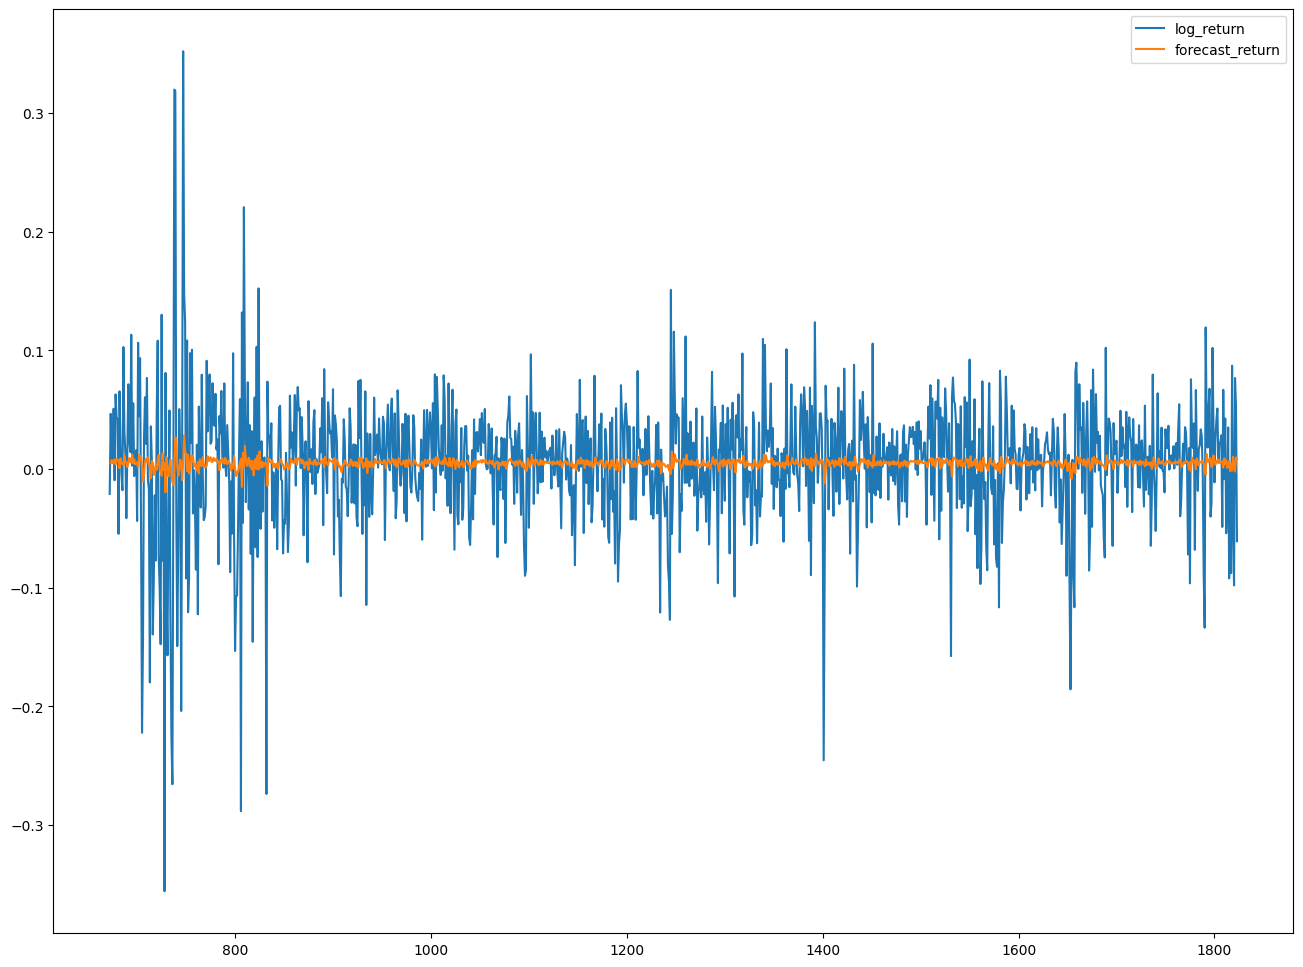

In [27]:
arima_model = sm.tsa.ARIMA(sp500_df_filtered['log_return'].iloc[1:],order=(1,0,0))
results = arima_model.fit()
sp500_df_filtered.loc[:, 'forecast_return'] = results.fittedvalues
sp500_df_filtered[['log_return', 'forecast_return']].plot(figsize=(16,12))

The model seems to be able to predict tiny variation/movement, but for the most part it is not a very good forecast. Hence, the reason we will move on to more advanced machine learning models and see if we can get better forecasts.

## <a id='part3'> Part 3: Gaussian Process Model</a>
- **Objective**: Create a gaussian process regression to model price and returns.
- **Tasks:**
  - GridSearch
  - Create a gaussian process
  - Train & Evaluate

#### GridSearch CV & Prediction -Continuous Targets



In [49]:
sp500_all.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,rfree,infl,ltr,corpr,svar,csp,crsp_spvw,crsp_spvwx,date,first_diff,og_var,log_index,log_var,log_return,dp,logret,logindex,dp_lag1,dp_lag2,dp_lag3,dp_lag4,svar_lag1,svar_lag2,svar_lag3,svar_lag4,bm_lag1,bm_lag2,bm_lag3,bm_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,forecast_return,bm_x_corpr,tbl_x_svar,aaa_x_svar,baa_x_svar,lty_x_svar,rfree_x_svar,corpr_x_bm_lag1,corpr_x_bm_lag2,corpr_x_bm_lag3,corpr_x_bm_lag4,svar_x_dp,svar_x_dp_lag1,svar_x_dp_lag2,svar_x_dp_lag3,svar_x_dp_lag4,svar_x_logret_lag3
672,192701,13.21,0.6967,1.229,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,0.0025,-0.011299,0.0075,0.0056,0.000470,NaN,-0.002910,-0.005579,1927-01-01,-0.28,NaN,2.580974,NaN,-0.020975,-2.942374,-0.020975,2.580974,-2.973012,-2.967499,-2.956452,-2.999471,0.000465,0.000539,0.002161,0.000741,0.441476,0.443309,0.460334,0.438713,0.016443,0.022096,-0.031845,0.022642,NaN,0.002485,0.000015,0.000022,0.000026,0.000016,1.174737e-06,0.002472,0.002483,0.002578,0.002457,-0.001383,-0.001397,-0.001394,-0.001389,-0.001409,-0.000015
673,192702,13.84,0.7033,1.218,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,0.0026,-0.005714,0.0088,0.0069,0.000287,NaN,0.045522,0.040566,1927-02-01,0.63,NaN,2.627563,NaN,0.046589,-2.979535,0.046589,2.627563,-2.942374,-2.973012,-2.967499,-2.956452,0.000470,0.000465,0.000539,0.002161,0.443706,0.441476,0.443309,0.460334,-0.020975,0.016443,0.022096,-0.031845,0.004925,0.002957,0.000009,0.000013,0.000016,0.000010,7.470692e-07,0.003062,0.003046,0.003059,0.003176,-0.000856,-0.000845,-0.000854,-0.000853,-0.000849,0.000006
674,192703,13.93,0.7100,1.208,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,0.0030,-0.005747,0.0253,0.0083,0.000924,NaN,0.007324,0.002610,1927-03-01,0.09,NaN,2.634045,NaN,0.006482,-2.976535,0.006482,2.634045,-2.979535,-2.942374,-2.973012,-2.967499,0.000287,0.000470,0.000465,0.000539,0.428501,0.443706,0.441476,0.443309,0.046589,-0.020975,0.016443,0.022096,0.007761,0.003899,0.000030,0.000043,0.000051,0.000031,2.772578e-06,0.003557,0.003683,0.003664,0.003679,-0.002751,-0.002754,-0.002719,-0.002748,-0.002743,0.000015
675,192704,14.17,0.7167,1.197,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.0025,0.000000,-0.0005,0.0055,0.000603,NaN,0.013021,0.010907,1927-04-01,0.24,6.732009,2.651127,0.028646,0.017082,-2.984225,0.017082,2.651127,-2.976535,-2.979535,-2.942374,-2.973012,0.000924,0.000287,0.000470,0.000465,0.469765,0.428501,0.443706,0.441476,0.006482,0.046589,-0.020975,0.016443,0.005031,0.002512,0.000020,0.000028,0.000033,0.000020,1.506472e-06,0.002584,0.002357,0.002440,0.002428,-0.001798,-0.001794,-0.001795,-0.001773,-0.001792,-0.000013
676,192705,14.91,0.7233,1.186,0.434783,0.0333,0.0457,0.0550,0.0327,0.055275,0.0030,0.005780,0.0109,-0.0011,0.000392,NaN,0.062353,0.057096,1927-05-01,0.74,7.187314,2.702032,0.030265,0.050905,-3.025963,0.050905,2.702032,-2.984225,-2.976535,-2.979535,-2.942374,0.000603,0.000924,0.000287,0.000470,0.456754,0.469765,0.428501,0.443706,0.017082,0.006482,0.046589,-0.020975,0.005753,-0.000478,0.000013,0.000018,0.000022,0.000013,1.175201e-06,-0.000502,-0.000517,-0.000471,-0.000488,-0.001185,-0.001169,-0.001166,-0.001167,-0.001153,0.000018


In [50]:
sp500_all = sp500_all.copy()
sp500_all['date'] = pd.to_datetime(sp500_all['date'])
train_data = sp500_all[sp500_all['date'] < '2022-01-01']
test_data = sp500_all[sp500_all['date'] >= '2022-01-01']

In [51]:
sp500_all.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'first_diff', 'og_var', 'log_index', 'log_var',
       'log_return', 'dp', 'logret', 'logindex', 'dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4', 'logret_lag1',
       'logret_lag2', 'logret_lag3', 'logret_lag4', 'forecast_return',
       'bm_x_corpr', 'tbl_x_svar', 'aaa_x_svar', 'baa_x_svar', 'lty_x_svar',
       'rfree_x_svar', 'corpr_x_bm_lag1', 'corpr_x_bm_lag2', 'corpr_x_bm_lag3',
       'corpr_x_bm_lag4', 'svar_x_dp', 'svar_x_dp_lag1', 'svar_x_dp_lag2',
       'svar_x_dp_lag3', 'svar_x_dp_lag4', 'svar_x_logret_lag3'],
      dtype='object')

In [52]:
features = ['d12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 
       'dp', 'dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4', 'logret_lag1',
       'logret_lag2', 'logret_lag3', 'logret_lag4',
       'bm_x_corpr', 'tbl_x_svar', 'aaa_x_svar', 'baa_x_svar', 'lty_x_svar',
       'rfree_x_svar', 'corpr_x_bm_lag1', 'corpr_x_bm_lag2', 'corpr_x_bm_lag3',
       'corpr_x_bm_lag4', 'svar_x_dp', 'svar_x_dp_lag1', 'svar_x_dp_lag2',
       'svar_x_dp_lag3', 'svar_x_dp_lag4', 'svar_x_logret_lag3']

In [53]:
#diffkernels
white_kernel = WhiteKernel(noise_level=0.5)
constant_kernel = ConstantKernel(1.0)
rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
# rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
dot_product_kernel = DotProduct(sigma_0=1)

kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel]

In [54]:
#gaussian process function
def gaussian_process(train_data, target, features, kernel_options, n_splits=5):
    """
    Function to perform a gridsearch to find the best hyperparmeters for the Gaussian Process model.

    Parameters:
        - train_data (DataFrame): dataframe containing the training data.
        - target (str): string indicating which is the target variable.
        - features (list of strngs): A list of strings indicating which features to include in the gridsearch.
        - kernel_options (list of objects): List containing the different kernel objects.
        - n_splits (int): Integer indicating how many splits to use for the cross-validation in gridsearch.

    Returns:
        - avg_mse (float): The average MSE calculated from all folds during the gridsearch.
        - best_r2 (float): The best R squared value.
        - best_model (object): The best-performing estimator found during gridsearch, fitted to the data.
    """
    X = train_data[features]
    y = train_data[target]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=10)), 
        ('scaler', StandardScaler()),
        ('gp', GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=50, random_state=0))
    ])

    param_grid = {
        'gp__kernel': kernel_options, 
        'gp__alpha': [0.01, 0.001]
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=tscv
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    feature_selector = best_model.named_steps['feature_selection']

    selected_indices = feature_selector.get_support(indices=True)
    selected_features = [features[i] for i in selected_indices]




    cv_results = grid_search.cv_results_
    avg_mse = -np.mean(cv_results['mean_test_score'])  
    best_r2 = r2_score(y, best_model.predict(X)) 

    return avg_mse, best_r2, best_model, selected_features

In [55]:
target_return = 'log_return'

mse, r2, best_gp_model, best_featues = gaussian_process(train_data, target_return, features, kernel_options, n_splits=5)
print(f'Best MSE Score: {mse}')
print(f'Best R2 Score: {r2}')
print(f'Best Params: {best_gp_model}')
print(f"Selected Features: {best_featues}")


Best MSE Score: 0.005316803850788653
Best R2 Score: 0.9999965141433171
Best Params: Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x000001C60C16A340>)),
                ('scaler', StandardScaler()),
                ('gp',
                 GaussianProcessRegressor(alpha=0.001,
                                          kernel=1**2 * Matern(length_scale=1, nu=1.5),
                                          n_restarts_optimizer=50,
                                          normalize_y=True, random_state=0))])
Selected Features: ['svar', 'tbl_x_svar', 'aaa_x_svar', 'lty_x_svar', 'rfree_x_svar', 'svar_x_dp', 'svar_x_dp_lag1', 'svar_x_dp_lag2', 'svar_x_dp_lag3', 'svar_x_dp_lag4']


In [39]:
print(best_featues)

['svar', 'tbl_x_svar', 'aaa_x_svar', 'lty_x_svar', 'rfree_x_svar', 'svar_x_dp', 'svar_x_dp_lag1', 'svar_x_dp_lag2', 'svar_x_dp_lag3', 'svar_x_dp_lag4']


In [57]:
# Ensure test data only uses the selected features
X_test = test_data[features]
y_test = test_data[target_return]
y_test_pred = best_gp_model.predict(X_test)

# Calculate metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Save predictions
test_data['gp_pred'] = y_test_pred

# Print metrics
print(f"Test Data MSE: {test_mse}")
print(f"Test R2 Score: {test_r2}")

Test Data MSE: 0.004609427540238621
Test R2 Score: -0.13183463463098533


C:\Users\amber\AppData\Local\Temp\ipykernel_42256\2753389063.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['gp_pred'] = y_test_pred


In [237]:
test_data = test_data.copy()  # Create an independent copy
test_data['gp_pred_original'] = y_test_pred

In [238]:
test_data[['log_return', 'gp_pred_original']].head()

,log_return,gp_pred_original
1812,-0.054018,-0.006193
1813,-0.031863,-0.009341
1814,0.035148,-0.023746
1815,-0.092068,-0.022611
1816,0.000053,-0.022021


## <a id='part4'> Part 4: Neural Network</a>
- **Objective**: Create a neural network to model return and price.
- **Tasks:**
  - Feature selection: Random Forest Feature Selection
  - Create a neural network, discuss hyper parameter tuning.


In [250]:
#build our pytorch model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, activation):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'logistic':
                layers.append(nn.Sigmoid())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, 1)) #output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#train model func
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=1000, patience=10, lambda_l1=0.001):
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        
        loss = criterion(outputs, y_train)
        l1_loss = 0
        for param in model.parameters():
            l1_loss += torch.sum(torch.abs(param))
        
        total_loss = loss + lambda_l1 * l1_loss
        
        total_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        train_losses.append(total_loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses


In [251]:
# Grid search for logret
param_grid = {
    'hidden_layer_sizes': [(20,), (20, 20), (50,), (100,), (100, 100), (50, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': ['adam', 'sgd'],
    'lambda_l1': [0.0, 0.001, 0.01]  # Add L1 regularization strength
}

# Preparing data
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features])
y_train = train_data[target_return].values
X_test = scaler.transform(test_data[features])
y_test = test_data[target_return].values

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

best_model = None
best_params = None
best_score = float('inf')

for train_idx, val_idx in tscv.split(X_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    for hidden_layers, activation, lr, opt_name, lambda_l1 in product(*param_grid.values()):
        # Initialize the model
        model = MLPModel(input_size=X_t.shape[1], hidden_layers=hidden_layers, activation=activation)
        
        # Define the loss function
        criterion = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr) if opt_name == 'adam' else optim.SGD(model.parameters(), lr=lr)

        # Train the model with L1 regularization
        trained_model, _, _ = train_model(
            model, criterion, optimizer, X_t, y_t, X_v, y_v, epochs=500, patience=10, lambda_l1=lambda_l1
        )

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_preds = trained_model(X_v)
            val_loss = criterion(val_preds, y_v).item()

        # Check if this is the best model so far
        if val_loss < best_score:
            best_score = val_loss
            best_model = trained_model
            best_params = {
                'hidden_layer_sizes': hidden_layers,
                'activation': activation,
                'learning_rate': lr,
                'optimizer': opt_name,
                'lambda_l1': lambda_l1
            }

print(f"Best parameters: {best_params}")
print(f"Best validation score: {best_score}")

# Testing on the test set
best_model.eval()
with torch.no_grad():
    test_preds = best_model(X_test).numpy()


Early stopping at epoch 12
Early stopping at epoch 27
Early stopping at epoch 37
Early stopping at epoch 24
Early stopping at epoch 39
Early stopping at epoch 49
Early stopping at epoch 331
Early stopping at epoch 34
Early stopping at epoch 38
Early stopping at epoch 94
Early stopping at epoch 193
Early stopping at epoch 12
Early stopping at epoch 195
Early stopping at epoch 19
Early stopping at epoch 321
Early stopping at epoch 139
Early stopping at epoch 160
Early stopping at epoch 242
Early stopping at epoch 251
Early stopping at epoch 31
Early stopping at epoch 16
Early stopping at epoch 336
Early stopping at epoch 467
Early stopping at epoch 36
Early stopping at epoch 10
Early stopping at epoch 159
Early stopping at epoch 22
Early stopping at epoch 59
Early stopping at epoch 21
Early stopping at epoch 273
Early stopping at epoch 37
Early stopping at epoch 30
Early stopping at epoch 80
Early stopping at epoch 92
Early stopping at epoch 153
Early stopping at epoch 23
Early stopping 

In [252]:
y_test_original = np.exp(y_test)
y_test_pred_original = np.exp(test_preds)

mse = mean_squared_error(y_test_original.numpy(), y_test_pred_original)
mae = mean_absolute_error(y_test_original.numpy(), y_test_pred_original)
r2 = r2_score(y_test_original.numpy(), y_test_pred_original)

print("Performance on test set:")
print(f"  MSE: {mse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")

Performance on test set:
  MSE: 0.004169686231762171
  MAE: 0.05633484199643135
  R2: -0.03448796272277832


C:\Users\amber\AppData\Local\Temp\ipykernel_3608\372884513.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_test_original = np.exp(y_test)


In [148]:
test_data['return'].describe()

count    12.000000
mean      0.984161
std       0.066311
min       0.906604
25%       0.934791
50%       0.963100
75%       1.040268
max       1.091116
Name: return, dtype: float64

In [127]:
# Correlation matrix to check if any feature is highly correlated with the target
correlation_matrix = train_data[features + [target_return]].corr()
print(correlation_matrix[target_return].sort_values(ascending=False))

log_return     1.000000
crsp_spvwx     0.995047
crsp_spvw      0.993762
corpr          0.181669
logret_lag1    0.073763
bm_lag2        0.061967
ltr            0.060562
bm_lag3        0.050993
bm_lag1        0.044035
e12            0.035735
logret_lag4    0.033828
d12            0.031451
bm_lag4        0.031160
infl           0.023687
dp_lag2        0.018875
dp_lag3        0.014750
dp_lag1        0.011243
svar_lag2      0.009000
dp_lag4        0.004513
aaa           -0.009295
lty           -0.009664
rfree         -0.013245
tbl           -0.015400
svar_lag4     -0.019080
baa           -0.022244
svar_lag1     -0.024456
logret_lag2   -0.024683
svar_lag3     -0.029704
ntis          -0.073537
logret_lag3   -0.080498
bm            -0.090543
dp            -0.102900
svar          -0.259413
Name: log_return, dtype: float64


In [144]:
test_data = test_data.copy()
test_data['logret_pred_nn'] = y_test_pred_original
test_data.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,bm_lag3,bm_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,forecast_return,return,gp_pred_original,logret_pred_nn
1812,202201,4515.55,60.9214,197.8833,0.181629,0.0015,0.0293,0.0358,0.0176,0.011640,...,0.178142,0.188541,0.042689,-0.008369,0.066858,-0.048738,0.007495,0.947415,0.977619,0.990970
1813,202202,4373.94,61.4457,197.8967,0.188270,0.0033,0.0325,0.0397,0.0193,0.008487,...,0.185043,0.178142,-0.054018,0.042689,-0.008369,0.066858,0.000914,0.968639,0.996116,1.003000
1814,202203,4530.41,61.9700,197.9100,0.206653,0.0044,0.0343,0.0429,0.0213,-0.001122,...,0.175599,0.185043,-0.031863,-0.054018,0.042689,-0.008369,0.002422,1.035773,0.995724,1.020719
1815,202204,4131.93,62.6532,196.0267,0.217314,0.0076,0.0376,0.0466,0.0275,-0.005663,...,0.181629,0.175599,0.035148,-0.031863,-0.054018,0.042689,0.006982,0.912043,0.983909,0.967087
1816,202205,4132.15,63.3364,194.1433,0.217228,0.0098,0.0413,0.0512,0.0290,-0.003372,...,0.188270,0.181629,-0.092068,0.035148,-0.031863,-0.054018,-0.001676,1.000053,1.052469,1.016114


## Plotting Results

#### Logindex Plot

In [240]:
test_data.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,rfree,infl,ltr,corpr,svar,csp,crsp_spvw,crsp_spvwx,date,first_diff,log_index,og_var,log_var,log_return,dp,logret,logindex,dp_lag1,dp_lag2,dp_lag3,dp_lag4,svar_lag1,svar_lag2,svar_lag3,svar_lag4,bm_lag1,bm_lag2,bm_lag3,bm_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,d12_x_corpr,d12_x_svar,e12_x_corpr,e12_x_svar,bm_x_baa,bm_x_ntis,bm_x_ltr,bm_x_corpr,bm_x_svar,bm_x_dp,bm_x_dp_lag1,bm_x_dp_lag2,bm_x_dp_lag3,bm_x_dp_lag4,bm_x_svar_lag3,bm_x_svar_lag4,bm_x_logret_lag1,bm_x_logret_lag2,bm_x_logret_lag3,tbl_x_ntis,tbl_x_infl,tbl_x_ltr,tbl_x_corpr,tbl_x_svar,tbl_x_svar_lag1,aaa_x_ntis,aaa_x_ltr,aaa_x_corpr,aaa_x_svar,aaa_x_logret_lag1,aaa_x_logret_lag3,baa_x_ntis,baa_x_ltr,baa_x_corpr,baa_x_svar,baa_x_logret_lag1,baa_x_logret_lag3,ntis_x_lty,ntis_x_rfree,ntis_x_svar,ntis_x_dp,ntis_x_dp_lag1,ntis_x_dp_lag2,ntis_x_dp_lag3,ntis_x_dp_lag4,ntis_x_svar_lag1,ntis_x_bm_lag1,ntis_x_bm_lag2,ntis_x_bm_lag3,ntis_x_bm_lag4,ntis_x_logret_lag3,lty_x_ltr,lty_x_corpr,lty_x_svar,lty_x_svar_lag1,lty_x_logret_lag1,rfree_x_ltr,rfree_x_corpr,rfree_x_svar,rfree_x_svar_lag1,infl_x_ltr,infl_x_corpr,infl_x_svar,infl_x_svar_lag1,infl_x_svar_lag2,infl_x_svar_lag3,infl_x_logret_lag1,ltr_x_svar,ltr_x_dp,ltr_x_dp_lag4,ltr_x_svar_lag3,ltr_x_svar_lag4,ltr_x_bm_lag1,ltr_x_bm_lag2,ltr_x_bm_lag3,ltr_x_bm_lag4,ltr_x_logret_lag3,ltr_x_logret_lag4,corpr_x_svar,corpr_x_dp,corpr_x_dp_lag1,corpr_x_dp_lag2,corpr_x_dp_lag3,corpr_x_dp_lag4,corpr_x_svar_lag1,corpr_x_svar_lag2,corpr_x_svar_lag3,corpr_x_svar_lag4,corpr_x_bm_lag1,corpr_x_bm_lag2,corpr_x_bm_lag3,corpr_x_bm_lag4,corpr_x_logret_lag1,corpr_x_logret_lag3,corpr_x_logret_lag4,svar_x_dp,svar_x_dp_lag1,svar_x_dp_lag2,svar_x_dp_lag3,svar_x_dp_lag4,svar_x_svar_lag1,svar_x_svar_lag3,svar_x_svar_lag4,svar_x_bm_lag1,svar_x_bm_lag3,svar_x_bm_lag4,svar_x_logret_lag1,svar_x_logret_lag2,svar_x_logret_lag3,dp_x_bm_lag1,dp_x_bm_lag2,dp_x_bm_lag3,dp_x_bm_lag4,dp_x_logret_lag1,dp_x_logret_lag3,dp_lag1_x_bm_lag2,dp_lag1_x_bm_lag3,dp_lag1_x_logret_lag1,dp_lag1_x_logret_lag3,dp_lag2_x_bm_lag2,dp_lag2_x_logret_lag1,dp_lag3_x_bm_lag2,dp_lag4_x_bm_lag2,dp_lag4_x_bm_lag3,dp_lag4_x_logret_lag1,svar_lag1_x_bm_lag1,svar_lag1_x_bm_lag2,svar_lag1_x_bm_lag3,svar_lag1_x_logret_lag1,svar_lag1_x_logret_lag2,svar_lag1_x_logret_lag3,svar_lag2_x_bm_lag2,svar_lag2_x_bm_lag3,svar_lag2_x_logret_lag1,svar_lag2_x_logret_lag2,svar_lag2_x_logret_lag3,svar_lag3_x_svar_lag4,svar_lag3_x_logret_lag1,svar_lag3_x_logret_lag3,svar_lag4_x_logret_lag1,svar_lag4_x_logret_lag2,svar_lag4_x_logret_lag3,bm_lag1_x_bm_lag2,bm_lag1_x_bm_lag3,bm_lag1_x_bm_lag4,bm_lag1_x_logret_lag1,bm_lag1_x_logret_lag2,bm_lag1_x_logret_lag3,bm_lag2_x_bm_lag3,bm_lag2_x_bm_lag4,bm_lag2_x_logret_lag1,bm_lag2_x_logret_lag2,bm_lag2_x_logret_lag3,bm_lag3_x_bm_lag4,bm_lag3_x_logret_lag1,bm_lag3_x_logret_lag2,bm_lag3_x_logret_lag3,bm_lag4_x_logret_lag1,bm_lag4_x_logret_lag2,bm_lag4_x_logret_lag3,logret_lag1_x_logret_lag3,logret_lag1_x_logret_lag4,return,gp_pred,gp_pred_original
1812,202201,4515.55,60.9214,197.8833,0.181629,0.0015,0.0293,0.0358,0.0176,0.011640,0.0000,0.008415,-0.0227,-0.0522,0.002780,NaN,-0.052243,-0.053087,2022-01-01,-250.63,8.415282,NaN,NaN,-0.054018,-4.305698,-0.054018,8.415282,-4.368359,-4.331997,-4.346731,-4.286281,0.002518,0.001327,0.001151,0.001393,0.175599,0.185043,0.178142,0.188541,0.042689,-0.008369,0.066858,-0.048738,-3.180097,0.169365,-10.329508,0.550127,0.006502,0.002114,-0.004123,-0.009481,0.000505,-0.782040,-0.793421,-0.786817,-0.789493,-0.778513,0.000209,0.000253,0.007753,-0.001520,0.012143,0.000017,0.000013,-0.000034,-0.000078,0.000004,0.000004,0.000341,-0.000665,-0.001529,0.000081,0.001251,0.001959,0.000417,-0.000813,-0.001869,0.000100,0.001528,0.002394,0.000205,0.000000e+00,0.000032,-0.050120,-0.050850,-0.050426,-0.050598,-0.049894,0.000029,0.002044,0.002154,0.002074,0.002195,0.000778,-0.000400,-0.000919,0.000049,0.000044,0.000751,-0.000000,-0.000000,0.000000e+00,0.000000e+00,-0.000191,-0.000439,0.000023,0.000021,0.0

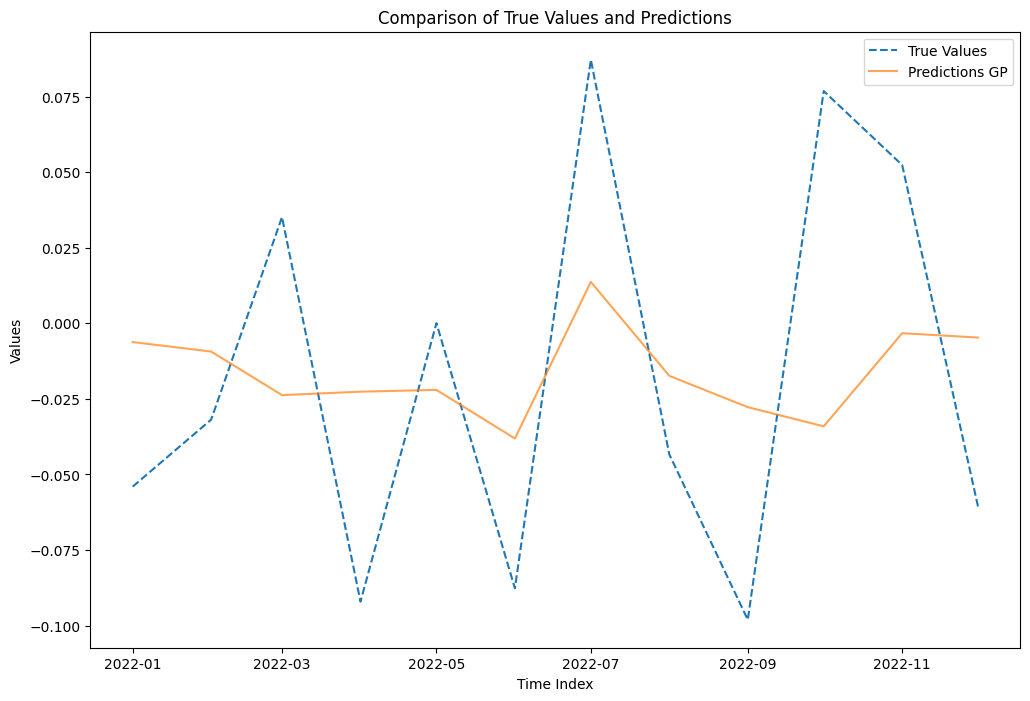

In [241]:
# Evaluation of Results
df_return_res = pd.DataFrame(
    {'true': test_data['log_return'], 'pred_gp': test_data['gp_pred_original']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_return_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_return_res['date'] = pd.to_datetime(df_return_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_return_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_return_res['true'], label='True Values', linestyle='--')
# plt.plot(df_return_res['arima'], label='Predicatons ARIMA', alpha=0.7)
# plt.plot(df_return_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_return_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [126]:
test_data[['return', 'logret_pred_nn']].head()

,return,logret_pred_nn
1812,0.947415,0.947984
1813,0.968639,0.969249
1814,1.035773,1.038053
1815,0.912043,0.914084
1816,1.000053,0.997340


In [66]:
test_data.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'index_return', 'first_diff', 'nat_log_index',
       'og_var', 'log_var', 'logged_first_diff', 'dp', 'logret', 'logindex',
       'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2',
       'svar_lag3', 'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4',
       'logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4',
       'forecast_index', 'forecast_return', 'gp_index_pred', 'gp_logret_pred',
       'logret_pred_nn', 'index_pred_nn'],
      dtype='object')

#### Logret (Returns) Plot

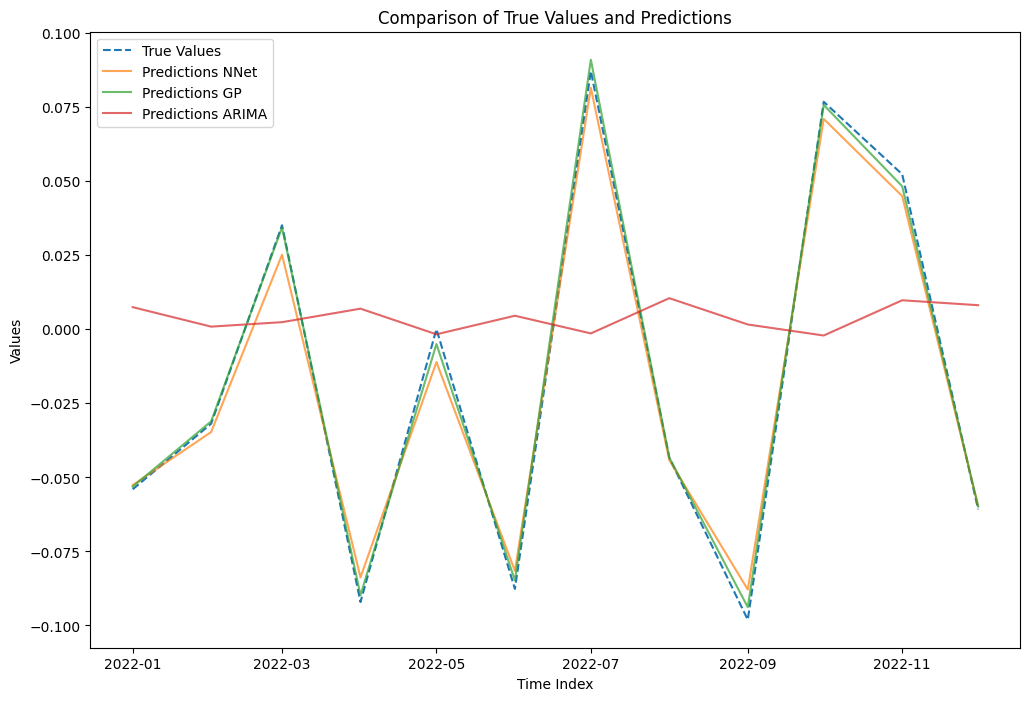

In [68]:
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': test_data['logret_pred_nn'], 'pred_gp': test_data['gp_logret_pred'], 'pred_arima': test_data['forecast_return']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logret_res['pred_arima'], label="Predictions ARIMA", alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()
